In [4]:
# data manipulation
import numpy as np
import pandas as pd

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn models & tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.utils import resample

# for emacs jupyter
%matplotlib inline
import matplotlib as mpl
mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["axes.facecolor"] = "white"
mpl.rcParams["savefig.facecolor"] = "white"


In [2]:
# Load data
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
submission = pd.read_csv("./data/sample_submission.csv")


Text(0, 0.5, 'Index')

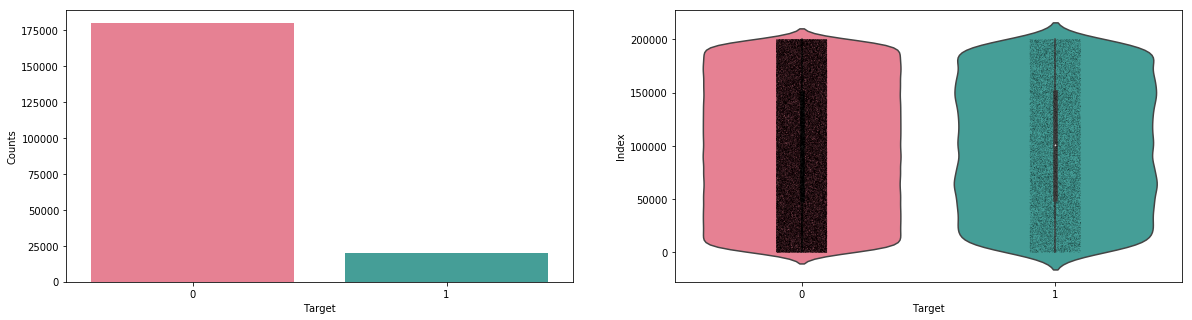

In [5]:
# Display the total number of each class. The plot suggests that it is an imbalanced problem.

fig, ax = plt.subplots(1,2,figsize=(20,5))
sns.countplot(train.target.values, ax=ax[0], palette="husl")
sns.violinplot(x=train.target.values, y=train.index.values, ax=ax[1], palette="husl")
sns.stripplot(
    x=train.target.values, y=train.index.values,
    jitter=True, ax=ax[1], color="black", size=0.5, alpha=0.5
)
ax[0].set_xlabel("Target")
ax[0].set_ylabel("Counts")
ax[1].set_xlabel("Target")
ax[1].set_ylabel("Index")


In [6]:
# Ratio of two classes
train.loc[train.target==1].shape[0] / train.loc[train.target==0].shape[0]

0.1117163789174106

In [7]:
# Drop useless ID_code
train.drop("ID_code", axis=1, inplace=True)
test.drop("ID_code", axis=1, inplace=True)

In [8]:
n_majority = train.loc[train.target==0].shape[0]
n_minority = train.loc[train.target==1].shape[0]

print("There are {} transactions.".format(n_minority))
print("There are {} non-transactions.".format(n_majority))
print("There are {} total samples.".format(train.shape[0]))
print("There are {} total features".format(train.shape[1]))


There are 20098 transactions.
There are 179902 non-transactions.
There are 200000 total samples.
There are 201 total features


In [9]:
# Upsample minority datapoints to augment its signal

class_ratio = 0.5
train_majority = train[train.target==0]
train_minority = train[train.target==1]

train_minority_upsampled = resample(
    train_minority,
    replace=True,
    n_samples=round(n_majority * class_ratio),
    random_state=42,
)

train_upsampled = pd.concat([train_majority, train_minority_upsampled])

# Display new class counts
train_upsampled.target.value_counts()


0    179902
1     89951
Name: target, dtype: int64

In [10]:
# Shuffle the whole dataset
train_upsampled = train_upsampled.sample(frac=1, random_state=42)
train_upsampled.head(5)


        target    var_0   var_1    var_2    var_3    var_4    var_5   var_6  \
196668       0  10.7622 -0.5062  12.4652   3.4901  11.5537  -8.5679  5.7316   
105410       1  12.6072  3.1179  10.7357  10.2591  12.2754 -19.5966  6.0209   
4035         0  12.2001  1.5880  12.1040   5.9779  10.9109  -0.4901  4.2466   
111343       0  11.1455 -5.2120  12.2593   7.9154  10.4304  -4.9595  6.5057   
39186        1  11.9693 -2.6781  15.2397   3.3661  10.2158  -7.0741  5.4540   

          var_7   var_8  ...  var_190  var_191  var_192  var_193  var_194  \
196668  20.5828 -4.4301  ...   0.0879   9.3729   2.8381   0.4777  14.8344   
105410  14.8977 -1.1910  ...   1.8312   8.0147   1.5485   2.4222  17.6325   
4035    17.1940  1.7418  ...  -6.1148   8.0607   3.3973   8.2254  16.8979   
111343  21.4432 -2.5402  ...   3.4457   4.8361  -1.2369   5.9734  19.1013   
39186   12.6401 -0.1606  ...  -2.8142   6.5331   0.4139  12.5029  17.6555   

        var_195  var_196  var_197  var_198  var_199  
196668  

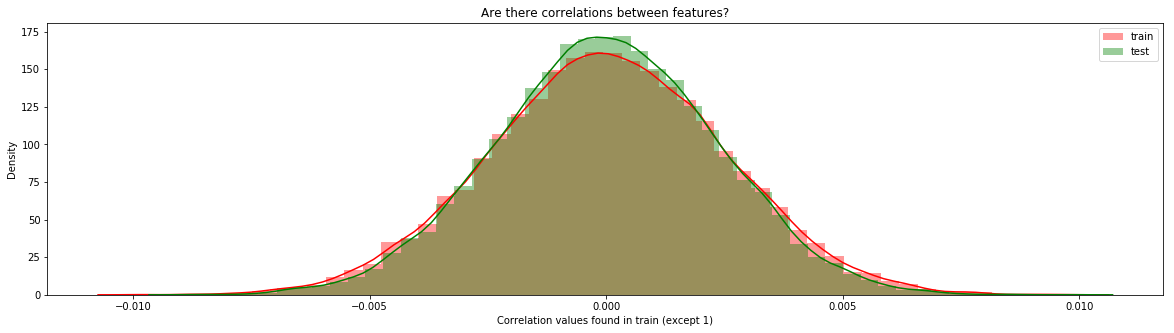

In [11]:
# Check linear correlations between each feature.
# The plot shows no linear correlation.

train_correlations = train.drop(["target"], axis=1).corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

test_correlations = test.corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Red", label="train")
sns.distplot(test_correlations, color="Green", label="test")
plt.xlabel("Correlation values found in train (except 1)")
plt.ylabel("Density")
plt.title("Are there correlations between features?"); 
plt.legend();

In [12]:
parameters = {"min_samples_leaf": [20, 25]}
forest = RandomForestClassifier(max_depth=15, n_estimators=15)
grid = GridSearchCV(forest, parameters, cv=3, n_jobs=-1, verbose=2, scoring=make_scorer(roc_auc_score))

In [13]:
grid.fit(train_upsampled.drop("target", axis=1).values, train_upsampled.target.values)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[Parallel(n_jobs=-1)]: Done   3 out of   6 | elapsed:  1.1min remaining:  1.1min


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:  1.1min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=15, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'min_samples_leaf': [20, 25]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring=make_scorer(roc_auc_score), verbose=2)

In [14]:
grid.best_score_

0.7031772549093687

In [15]:
grid.best_params_

{'min_samples_leaf': 20}

Text(0.5, 1.0, 'Waht are the top important features to start with?')

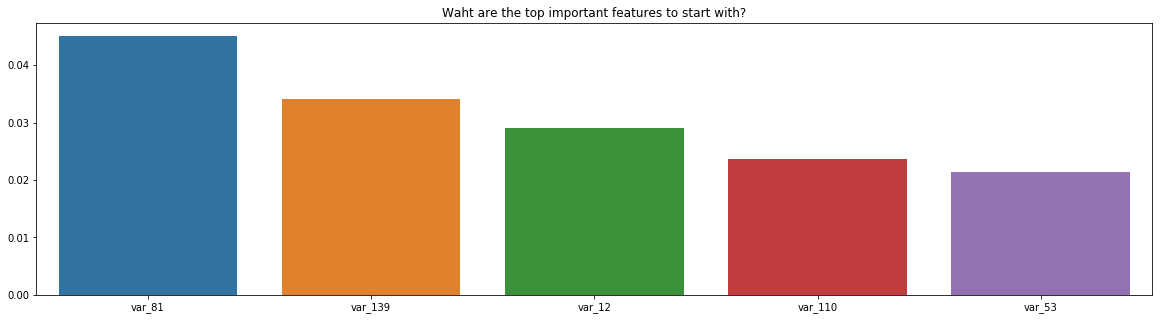

In [16]:
n_top = 5
importances = grid.best_estimator_.feature_importances_
idx = np.argsort(importances)[::-1][0:n_top]
feature_names = train.drop("target", axis=1).columns.values

plt.figure(figsize=(20,5))
sns.barplot(x=feature_names[idx], y=importances[idx]);
plt.title("Waht are the top important features to start with?")


In [17]:
y_proba = grid.predict_proba(test.values)
y_proba_train = grid.predict_proba(train_upsampled.drop("target", axis=1).values)

In [18]:
submission["target"] = y_proba
submission.to_csv("./submission_files/submission_baseline_forest_upsampled.csv", index=False)